In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
%matplotlib inline


In [15]:
df = pd.read_csv('listings.csv')

# going to split the item name column

df[['knife', 'finish']] = df['item_name'].str.split("|", expand=True)
df['knife'] = df['knife'].str.replace('★', '').str.strip()

# Only remove StatTrak™ prefix if it exists
df['knife'] = df['knife'].str.replace('StatTrak™ ', '', regex=False).str.strip().str.lower()

df['finish'] = df['finish'].str.split("(").str[0].str.strip().str.lower()
df = df.drop('item_name', axis=1)


# turn null finishes into vanilla
df['finish'] = df['finish'].fillna("vanilla")


In [16]:
df.head()

,reference_predicted_price,item_wear,item_is_stattrak,item_rarity,item_quality,item_float_value,item_paint_index,knife,finish
0,13747,Minimal Wear,False,6,3,0.121366,44,kukri knife,case hardened
1,13747,Minimal Wear,False,6,3,0.117755,44,kukri knife,case hardened
2,10082,Field-Tested,False,6,3,0.267152,1106,falchion knife,lore
3,20487,Factory New,False,6,3,0.065176,59,classic knife,slaughter
4,12560,Battle-Scarred,False,6,3,0.533455,414,stiletto knife,rust coat


In [ ]:
df.isnull().sum()


reference_predicted_price      int64
item_wear                     object
item_is_stattrak                bool
item_rarity                    int64
item_quality                   int64
item_float_value             float64
item_paint_index               int64
knife                         object
finish                        object
dtype: object

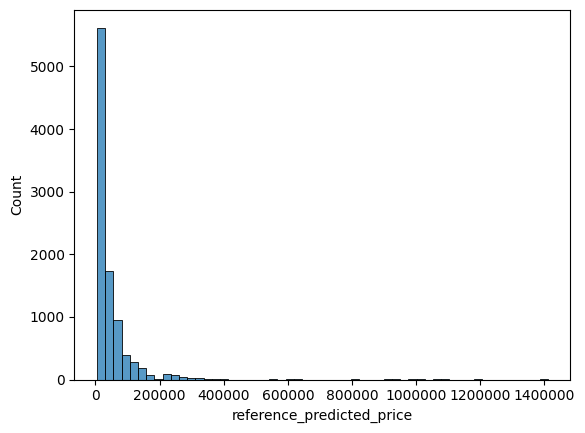

In [ ]:
# see distribution
sns.histplot(df.reference_predicted_price, bins=55)
plt.ticklabel_format(style='plain', axis='x')
plt.show()

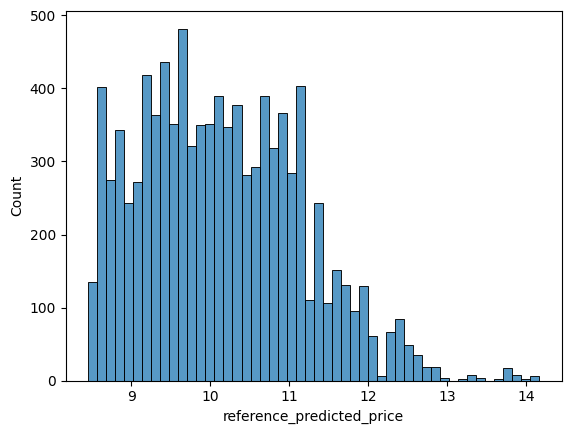

In [ ]:
# log tranform it so it works better

price_logs = np.log1p(df.reference_predicted_price)
sns.histplot(price_logs, bins = 50) 
plt.ticklabel_format(style='plain', axis='x')


In [52]:
# split data into train validation and test

from sklearn.model_selection import train_test_split


df_full_train, df_test = train_test_split(df, test_size=0.2)
df_train, df_val = train_test_split(df_full_train, test_size=0.25)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


y_train = (df_train.reference_predicted_price).astype('int').values
y_val = (df_val.reference_predicted_price).astype('int').values
y_test = (df_test.reference_predicted_price).astype('int').values
y_full_train = (df_full_train.reference_predicted_price).astype('int').values


# log them
y_train_log = np.log1p(y_train) 
y_val_log = np.log1p(y_val)
y_full_train_log = np.log1p(y_full_train)

del df_train['reference_predicted_price']
del df_val['reference_predicted_price']
del df_test['reference_predicted_price']


In [56]:
# imports

from sklearn.linear_model import Ridge

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
# dv code

dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)



,reference_predicted_price,item_wear,item_is_stattrak,item_rarity,item_quality,item_float_value,item_paint_index,knife,finish
0,13747,Minimal Wear,False,6,3,0.121366,44,kukri knife,case hardened
1,13747,Minimal Wear,False,6,3,0.117755,44,kukri knife,case hardened
2,10082,Field-Tested,False,6,3,0.267152,1106,falchion knife,lore
3,20487,Factory New,False,6,3,0.065176,59,classic knife,slaughter
4,12560,Battle-Scarred,False,6,3,0.533455,414,stiletto knife,rust coat
...,...,...,...,...,...,...,...,...,...
9545,14995,Field-Tested,False,6,3,0.331254,98,stiletto knife,ultraviolet
9546,15340,Minimal Wear,False,6,3,0.112631,59,kukri knife,slaughter
9547,19024,Field-Tested,False,6,3,0.270706,12,bayonet,crimson web
9548,20926,Factory New,False,6,3,0.012950,409,flip knife,tiger tooth


## linear regression with ridge

In [44]:

# Train lin reg
lr = Ridge()
lr.fit(X_train, y_train_log)


,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [48]:
# evaluate lin reg
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_val_pred_log = lr.predict(X_val)

y_val_pred = np.expm1(y_val_pred_log)  # inverse of log1p


val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f"MAE: {val_mae}")
print(f"RMSE: {val_rmse}")
print(f"R²: {val_r2}")

MAE: 13645.531986758922
RMSE: 69218.94092682692
R²: 0.4647241668030474


In [54]:
# train final model with test and validation
full_train_dicts = df_full_train.to_dict(orient='records')
X_full_train = dv.transform(full_train_dicts)
lr.fit(X_full_train, y_full_train_log)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


## random forest

In [69]:
# transform validation and test sets
X_val = dv.transform(df_val.to_dict(orient='records'))
X_test = dv.transform(df_test.to_dict(orient='records'))

# tune hyperparams
best_score = -np.inf
best_params = {}

for n in [50, 100, 200, 500]:
    for depth in [10, 20, 50, 100, None]:
        for min_samples in [1, 3, 5]:
            rf = RandomForestRegressor(
                n_estimators=n,
                max_depth=depth,
                min_samples_leaf=min_samples,
                random_state=42,
                n_jobs=-1
            )
            rf.fit(X_train, y_train)  
            score = rf.score(X_val, y_val)  
            if score > best_score:
                best_score = score
                best_params = {
                    'n_estimators': n,
                    'max_depth': depth,
                    'min_samples_leaf': min_samples
                }

# train model on training
rf_final = RandomForestRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1
)
rf_final.fit(X_train, y_train) 

# evaluate on validation
y_val_pred = rf_final.predict(X_val)
mae = mean_absolute_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)

print("Best Hyperparameters:")
print(best_params)
print("\nValidation Set Performance:")
print(f"  MAE: {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  R²: {r2:.4f}")


Best Hyperparameters:
{'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 5}

Validation Set Performance:
  MAE: 41352.54
  RMSE: 81387.05
  R²: -0.0666
